In [1]:
# # Step 1: Install the package

# !pip install scikit-survival
# !pip install lifelines
# !pip install shap

In [2]:
# Step 2: Load packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from lifelines import CoxPHFitter 
from lifelines.utils import k_fold_cross_validation
from lifelines.statistics import logrank_test

from lifelines import KaplanMeierFitter 
from lifelines.plotting import add_at_risk_counts


from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

import shap

sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Step 3: Load data
file1 = pd.read_csv('Data/data_clinical_patient.csv')
file2 = pd.read_csv('Data/Gene_MRMR_50.csv')


In [4]:
# 3.1 Merge gene data with OS time and status
data = pd.merge(file1[['PATIENT_ID','OS_MONTHS','OS_STATUS']],file2, how="inner", on=["PATIENT_ID"])

In [5]:
# Have a quick look on data
data.head()

,PATIENT_ID,OS_MONTHS,OS_STATUS,FGF3,BQ771683,ATP9A,BU193864,KPRP,C20orf70,AICDA,...,GFAP,WAKMAR2,AW296252,ACTC1,ZP4,AA724305,BCHE,KRT27,TMED6,CHRNA9
0,MB-0000,140.500000,0:LIVING,-0.0825,0.6806,0.8716,-1.5397,1.1307,0.0133,-0.5217,...,0.3956,-1.3543,-0.3308,0.7053,-0.5424,0.2441,1.4695,0.1809,-0.1030,0.1405
1,MB-0002,84.633333,0:LIVING,0.0148,0.8684,1.5305,0.6892,0.7361,0.6267,-0.3076,...,-0.0696,0.3213,0.7097,0.0515,-0.8570,-0.8681,-0.0584,0.8304,-0.7869,-0.2039
2,MB-0005,163.700000,1:DECEASED,-0.8858,1.2296,0.4768,0.0539,-0.0153,-2.5094,0.7318,...,1.1399,0.1632,-0.1549,0.0027,0.3221,-1.6719,0.4846,-2.1079,0.4150,-0.1307
3,MB-0006,164.933333,0:LIVING,0.7010,-1.4373,2.2959,-2.2863,-0.9311,-0.2770,-0.4574,...,1.1406,-0.3601,-0.4868,0.8694,-0.4531,-0.6064,0.8052,-0.0573,-0.0103,-0.3090
4,MB-0008,41.366667,1:DECEASED,0.1681,0.7102,1.4258,-1.8666,0.4268,2.4541,0.3074,...,-0.1130,-0.4077,0.1531,-0.5942,0.2000,0.5982,0.0170,0.5860,0.7623,-0.4006


In [6]:
# Step 4: Preprocess data & Explore data

# 4.1 Drop unused columns
drop_list = ['PATIENT_ID']
df = data.drop(drop_list, axis=1)

print('After cleaning, the shape of data is', df.shape)

# 4.2 Check missing values again
print('Missing value number:', df.isna().sum().sum())

# 4.3 Encode OS status to dummy
df['OS_STATUS'] = np.where(df['OS_STATUS'] == '1:DECEASED', 1, 0)

After cleaning, the shape of data is (1904, 52)
Missing value number: 0


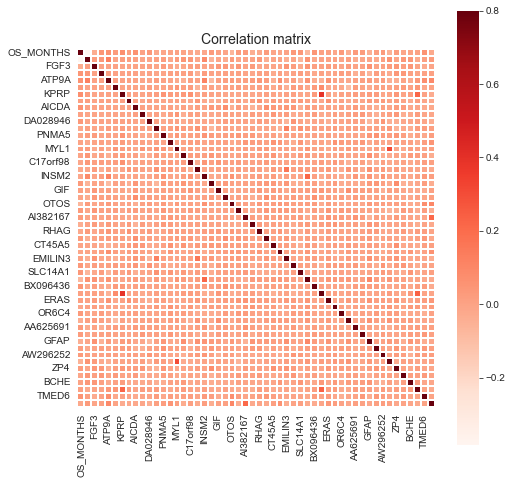

In [7]:
# 4.6 Correlation analysis
colormap = plt.cm.Reds
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(),linewidths=0.1,vmax=0.8, 
            square=True, cmap = colormap, linecolor='white')
plt.title('Correlation matrix', fontsize=14)
plt.savefig('Plot\Correlation_gene.pdf')   

42.1% of records are censored


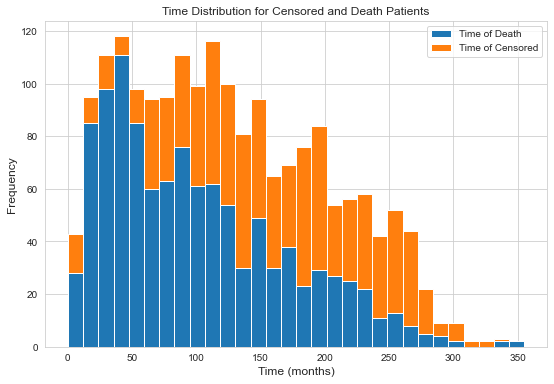

In [8]:
# 4.7 Time Distribution of Death and Censored
num_censored = df.shape[0] - df["OS_STATUS"].sum()
print("%.1f%% of records are censored" % (num_censored/df.shape[0]*100))

plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist((df.query('OS_STATUS == 1')['OS_MONTHS'],
                               df.query('OS_STATUS == 0')['OS_MONTHS']),
                              bins=30, stacked=True)
_ = plt.legend(patches, ["Time of Death", "Time of Censored"])
plt.title("Time Distribution for Censored and Death Patients")
plt.xlabel('Time (months)',fontsize='large')
plt.ylabel('Frequency',fontsize='large')
plt.savefig('Plot\Time_gene.pdf')   

In [9]:
# Step 5: Cox survival analysis
# 5.1: Normalise data
ss = MinMaxScaler()
df_norm = df.drop(['OS_STATUS', 'OS_MONTHS'], axis = 1)
df_norm = pd.DataFrame(ss.fit_transform(df_norm), columns=df_norm.columns)
df_norm['OS_STATUS'] = df['OS_STATUS']
df_norm['OS_MONTHS'] = df['OS_MONTHS']

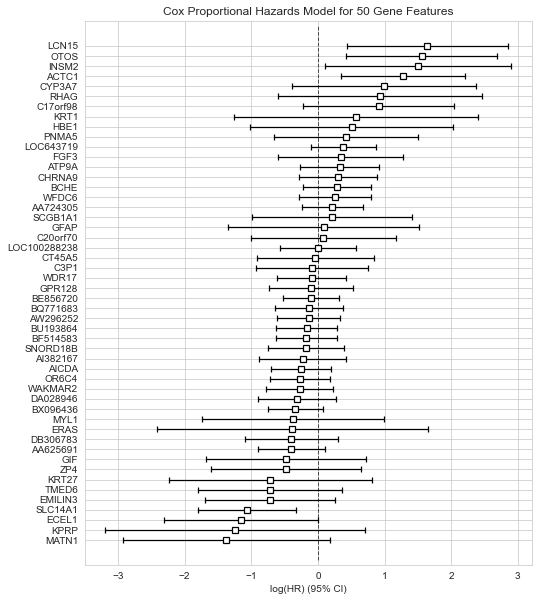

In [10]:
# 5.2: Build model 
# Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(df_norm, duration_col='OS_MONTHS', event_col='OS_STATUS')

# Plot
plt.figure(figsize=(8, 10))
plt.title('Cox Proportional Hazards Model for 50 Gene Features')
cph.plot()
plt.savefig('Plot\CPH_gene.png',bbox_inches='tight')  

In [11]:
# Report
cph.print_summary(columns=["coef","exp(coef)","exp(coef) lower 95%","exp(coef) upper 95%", "z", "p"], decimals=3)

<lifelines.CoxPHFitter: fitted with 1904 total observations, 801 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 1904
number of events observed = 1103
   partial log-likelihood = -7495.220
         time fit was run = 2022-02-17 23:02:52 UTC

---
               coef  exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%      z     p
covariate                                                                            
FGF3          0.344      1.411                0.551                3.609  0.718 0.473
BQ771683     -0.132      0.876                0.528                1.455 -0.510 0.610
ATP9A         0.328      1.388                0.766                2.512  1.082 0.279
BU193864     -0.169      0.844                0.532                1.341 -0.718 0.473
KPRP         -1.241      0.289                0.041                2.030 -1.248 0.212
C20orf70      0.080      1.083                0.366                3.209  0.144 0.885
AICDA        -0.257      0.774                0.493                1.215 -1.115 0.265
GPR128       -0.098      0.907                0.483                1.703 -0.304 0.761
DA028946     -0.319      0.727                0.404                1.308 -1.064 0.288
WFDC6         0.258      1.294                0.755                2.219  0.938 0.348
PNMA5         0.419      1.520                0.515                4.486  0.758 0.448
SNORD18B     -0.181      0.834                0.470                1.481 -0.619 0.536
MYL1         -0.371      0.690                0.176                2.702 -0.533 0.594
LOC643719     0.379      1.460                0.897                2.377  1.523 0.128
C17orf98      0.910      2.483                0.803                7.677  1.579 0.114
SCGB1A1       0.213      1.237                0.374                4.090  0.348 0.728
INSM2         1.507      4.512                1.117               18.224  2.115 0.034
ECEL1        -1.156      0.315                0.099                1.001 -1.958 0.050
GIF          -0.474      0.623                0.187                2.072 -0.772 0.440
WDR17        -0.093      0.911                0.543                1.527 -0.354 0.723
OTOS          1.556      4.741                1.517               14.811  2.677 0.007
BF514583     -0.179      0.836                0.529                1.321 -0.766 0.444
AI382167     -0.231      0.794                0.411                1.534 -0.686 0.493
HBE1          0.509      1.663                0.363                7.619  0.655 0.512
RHAG          0.930      2.535                0.550               11.680  1.193 0.233
MATN1        -1.374      0.253                0.054                1.196 -1.734 0.083
CT45A5       -0.039      0.962                0.401                2.307 -0.087 0.931
C3P1         -0.090      0.914                0.395                2.119 -0.209 0.834
EMILIN3      -0.725      0.484                0.182                1.287 -1.454 0.146
DB306783     -0.397      0.672                0.333                1.357 -1.108 0.268
SLC14A1      -1.067      0.344                0.165                0.715 -2.857 0.004
LCN15         1.643      5.173                1.546               17.302  2.668 0.008
BX096436     -0.338      0.713                0.474                1.074 -1.619 0.106
KRT1          0.566      1.761                0.283               10.972  0.606 0.544
ERAS         -0.389      0.678                0.089                5.179 -0.375 0.708
LOC100288238 -0.001      0.999                0.562                1.775 -0.004 0.997
OR6C4        -0.269      0.764                0.486                1.200 -1.169 0.243
CYP3A7        0.992      2.695                0.678               10.723  1.407 0.159
AA625691     -0.401      0.670                0.405                1.109 -1.558 0.119
BE856720     -0.099      0.906                0.595                1.379 -0.460 0.645
GFAP          0.0

In [12]:
# Cross validation (optional)
scores = k_fold_cross_validation(cph, df_norm, 'OS_MONTHS', event_col='OS_STATUS', k=5, 
                                scoring_method="concordance_index", seed=18)

print("Average score", np.mean(scores))

Average score 0.5312561451247788


In [13]:
# Step 6: Machine Learning Methods for Survival Analysis

# 6.1: Set up seed and the options for the cross-validation approach
SEED = 5
CV = KFold(n_splits=5, shuffle=True, random_state=0)

# 6.2 Split data to prepare for ML
X = df.drop(['OS_MONTHS','OS_STATUS'], axis = 1)
df['OS_STATUS'] = np.where(df['OS_STATUS'] == 1, True, False)
y = df[['OS_STATUS','OS_MONTHS']].to_records(index=False)

# Split the data set into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y['OS_STATUS'],
                                                    random_state=SEED)

In [14]:
# 6.3: Build model

# Define a function for grid search to tune training model
# and predict the results
def grid_search(estimator, param, X_train, y_train, X_test, y_test, CV):
    
    # Define Grid Search
    gcv = GridSearchCV(
    estimator,
    param_grid=param,
    cv=CV,
    n_jobs=-1).fit(X_train, y_train)

    # Find best model
    model = gcv.best_estimator_
    print(model)
    
    # Generate predictions
    prediction = model.predict(X_test)
    result = concordance_index_censored(y_test["OS_STATUS"], y_test["OS_MONTHS"], prediction)
    print('C-index for test set (Hold out):', result[0])

    return [model,  prediction]


In [15]:
# Re-run experiment 20 times 
def c_index(model, X, y, n=20):
    np.random.seed(1)
    seeds = np.random.permutation(1000)[:n]

    # Train and evaluate model with 20 times
    cindex_score = []
    predict_list = []
    
    for s in seeds:
        X_trn, X_test, y_trn, y_test = train_test_split(X, y, test_size=0.2, 
                                                        stratify=y['OS_STATUS'],
                                                        random_state=s)
        model.fit(X_trn, y_trn)
        prediction = model.predict(X_test)
        predict_list.append(prediction)
        result = concordance_index_censored(y_test["OS_STATUS"],y_test["OS_MONTHS"], prediction)
    
        cindex_score.append(round(result[0],3))

    print('Average C-index for {} runs'.format(n), np.mean(cindex_score))
    
    return [cindex_score, predict_list]

In [16]:
# Define the Pipeline and hyperparameter

# CoxPHSurvivalAnalysis
pipe_cox = Pipeline([('scaler', MinMaxScaler()),('model', CoxPHSurvivalAnalysis())])
param_cox ={'scaler': [MinMaxScaler()],
        "model__alpha": [0.001, 0.01, 0.1, 1, 10, 100]}

# Random Survival Forest
pipe_rsf = Pipeline([('scaler', MinMaxScaler()),('model', RandomSurvivalForest())])
param_rsf ={'scaler': [MinMaxScaler()],
        'model__random_state': [SEED],
        'model__max_features': ['sqrt'],
        'model__max_depth': [8],
        'model__min_samples_leaf': [50, 100],
        'model__min_samples_split': [100],
        'model__n_estimators':[500]}

# Gradient Boost Survival
pipe_gbs = Pipeline([('scaler', MinMaxScaler()),('model', GradientBoostingSurvivalAnalysis())])
param_gbs ={'scaler': [MinMaxScaler()],
        'model__random_state': [SEED],
        'model__learning_rate': [0.01, 0.1, 1],
        'model__n_estimators':[200, 500, 800, 1000]}

# Survival SVM
pipe_svm = Pipeline([('scaler', MinMaxScaler()),('model', FastSurvivalSVM())])
param_svm ={'scaler': [MinMaxScaler()],
        'model__random_state': [SEED],
        'model__max_iter': [500, 5000],
        'model__optimizer':['avltree', 'rbtree','simple']}

# Estimator list:
estimator_list = {'Cox Regression':[pipe_cox, param_cox ], 
                'Random Forest Survival':[pipe_rsf, param_rsf], 
                'Gradient Boosting Survival': [pipe_gbs, param_gbs], 
                'SVM Survival': [pipe_svm, param_svm]}

In [17]:
model_list = []
pred_list = []
c_index_list = []
pred_list_n = []

for model_name, index in estimator_list.items():
    print('\n',model_name)
    estimator = index[0]
    param = index[1]
    outcome = grid_search(estimator, param, X_train, y_train, X_test, y_test, CV)
    model = outcome[0]
    model_list.append(model)
    pred_list.append(outcome[1])

    # Run model n times to check c-index
    score, pre = c_index(model, X, y, n=20)
    c_index_list.append(score)
    pred_list_n.append(pre)

    


 Cox Regression
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model', CoxPHSurvivalAnalysis(alpha=0.001))])
C-index for test set (Hold out): 0.5157661773365008
Average C-index for 20 runs 0.5149500000000001

 Random Forest Survival
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 RandomSurvivalForest(max_depth=8, max_features='sqrt',
                                      min_samples_leaf=50,
                                      min_samples_split=100, n_estimators=500,
                                      random_state=5))])
C-index for test set (Hold out): 0.5301415199691377
Average C-index for 20 runs 0.53135

 Gradient Boosting Survival
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 GradientBoostingSurvivalAnalysis(n_estimators=1000,
                                                  random_state=5))])
C-index for test set (Hold out): 0.5120302125845161
Average C-index for 20 runs 0.52285



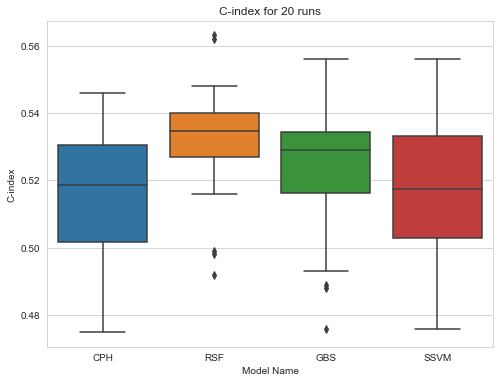

In [18]:
# Visualise results

name = ['CPH', 'RSF', 'GBS', 'SSVM']
cv_res = []

for i in range(0,4):
    for c in c_index_list[i]:
        cv_res.append([name[i],c])

c_plot = pd.DataFrame(cv_res, columns=['Model Name','C-index'])

plt.subplots(figsize=(8,6))
ax = sns.boxplot(x="Model Name", y="C-index", data=c_plot)
plt.title('C-index for 20 runs')
plt.savefig('Plot\Exp2_cindex.pdf') 

In [19]:
for i in range(0,4):
    print(name[i], np.median(c_index_list[i]))

CPH 0.5185
RSF 0.5345
GBS 0.529
SSVM 0.5175000000000001


(381, 51)

Model CPH


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           6.85 0.01      6.82

(381, 51)

Model RSF


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.37 0.07      3.91

(381, 51)

Model GBS


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.11 0.08      3.68

(381, 51)

Model SSVM


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.89 0.35      1.53

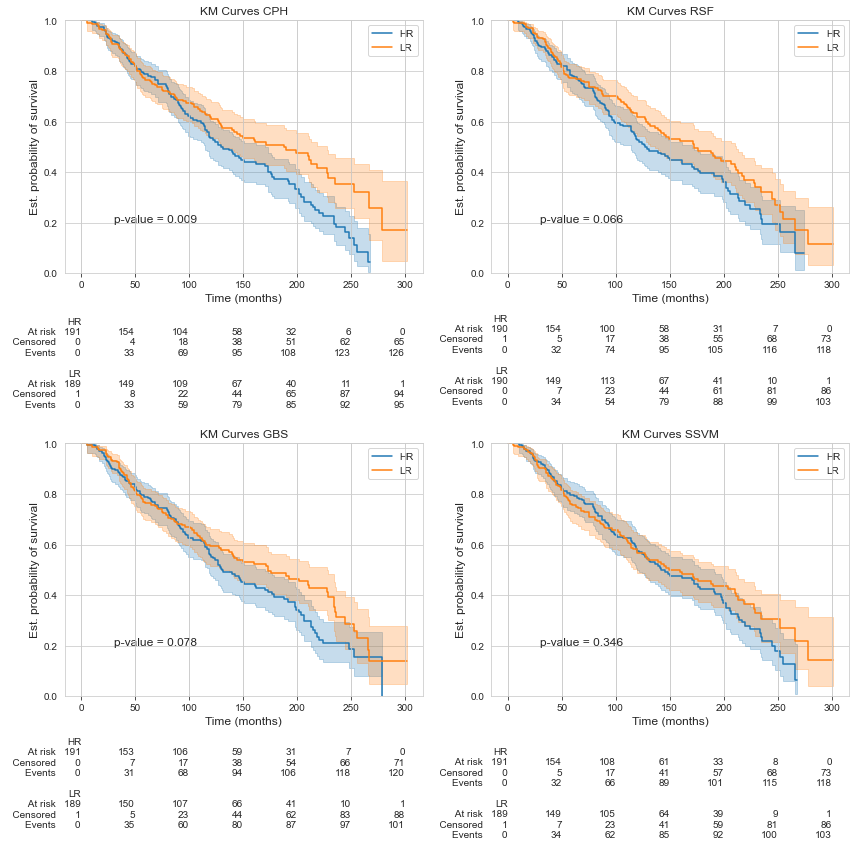

In [20]:
# KM Curve for median
fig, ax = plt.subplots(2,2,figsize=(12,12))
k  = 0
for pred in pred_list:
    df1 = X_test.reset_index(drop=True) 
    risk =[]
    
    y_pred = pred
    med = np.median(y_pred)
    r = np.where(y_pred >= med, 1, 0)

    df1['Risk'] = r
    print(df1.shape)
    ix = df1['Risk'] == 1

    df_y = pd.DataFrame(y_test)
    df_y['OS_STATUS'] = np.where(df_y['OS_STATUS'] == True, 1, 0)
    df1['OS_STATUS']= df_y['OS_STATUS']
    df1['OS_MONTHS']= df_y['OS_MONTHS']
    T_hr, E_hr = df1.loc[ix]['OS_MONTHS'], df1.loc[ix]['OS_STATUS']
    T_lr, E_lr = df1.loc[~ix]['OS_MONTHS'], df1.loc[~ix]['OS_STATUS']

    # Set-up plots
    k+=1
    plt.subplot(2,2,k)

    # Fit survival curves
    kmf_hr = KaplanMeierFitter()
    ax = kmf_hr.fit(T_hr, E_hr, label='HR').plot_survival_function()

    kmf_lr = KaplanMeierFitter()
    ax = kmf_lr.fit(T_lr, E_lr, label='LR').plot_survival_function()

    add_at_risk_counts(kmf_hr, kmf_lr)
    # Format graph
    plt.ylim(0,1)
    ax.set_xlabel('Time (months)',fontsize='large')
    ax.set_ylabel('Est. probability of survival',fontsize='large')

    # Calculate p-value
    res = logrank_test(T_hr, T_lr, event_observed_A=E_hr, event_observed_B=E_lr, alpha=.95)
    print('\nModel', name[k-1])
    res.print_summary()

    # Locate the label at the 1st out of 9 tick marks
    xloc = max(np.max(T_hr),np.max(T_lr)) / 10
    ax.text(xloc,.2,'p-value = {}'.format(round(res.p_value,3)),fontsize=12)
    ax.set_title('KM Curves {}' .format(name[k-1]))
    plt.tight_layout()
    plt.savefig('Plot\Exp2_KM.pdf') 


Model CPH


Permutation explainer: 382it [00:12,  7.48it/s]                         


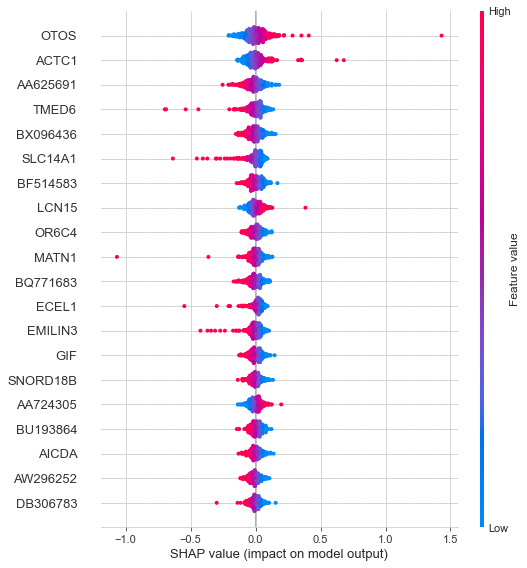


Model RSF


Permutation explainer: 382it [11:46:58, 111.33s/it]


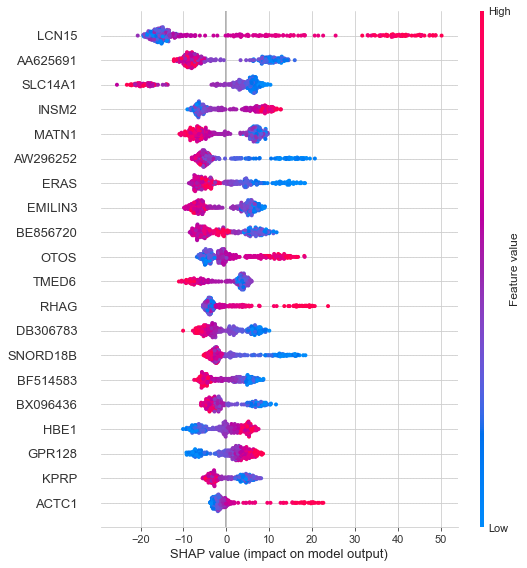


Model GBSurv


Permutation explainer: 382it [02:38,  2.26it/s]


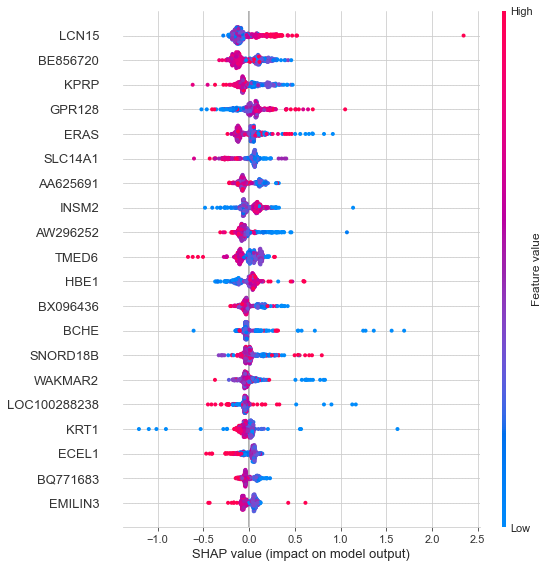


Model SurvSVM


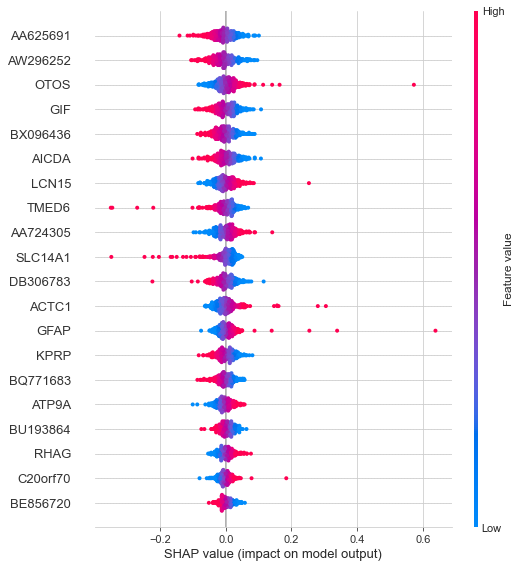

In [22]:
# Step 7: Interpret data
# Initialize JS For Plot
import shap
shap.initjs()

for i in range(0,4):
    print('\nModel', name[i])
    m = model_list[i][1]
    m.fit(X_train,y_train)
    explainer = shap.Explainer(m.predict, X_train, feature_names=X_train.columns)
    shaps = explainer(X_test)
    shap.summary_plot(shaps, X_test)